In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
np.random.seed(42)

%matplotlib inline
warnings.filterwarnings('ignore')

In [196]:
online_shoppers = pd.read_csv('online_shoppers_intention.csv')
online_shoppers.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Machine Learning Phase

- Categorical  Encodings, As All the Columns represent medium cardinality level I will use OneHotEncoding as the Categorical Encoder.

In [197]:
cols = online_shoppers.select_dtypes('object').columns
for col in cols:
    print(col, online_shoppers[col].nunique())

Month 10
VisitorType 3


In [198]:
online_shoppers.shape

(12330, 18)

In [199]:
dummy_df = pd.get_dummies(online_shoppers[cols]).replace({True:1, False:0})
online_shoppers.drop(cols, axis=1, inplace=True)
df = pd.concat([online_shoppers, dummy_df], axis=1)

In [200]:
df.shape

(12330, 29)

- Encode the Target column

In [201]:
df['Revenue'] = df['Revenue'].replace({True:1, False:0})

- Here we check the Multi-colinearity between the columns
- All the columns seems to have normal VIF so I will not drop any of them.

In [202]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.select_dtypes(float)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data.sort_values('VIF', ascending=False)

,feature,VIF
4,ExitRates,5.883227
3,BounceRates,5.499072
2,ProductRelated_Duration,1.557384
0,Administrative_Duration,1.367606
1,Informational_Duration,1.226617
6,SpecialDay,1.100394
5,PageValues,1.058360


In [203]:
(df.corr()['Revenue']).sort_values(key=abs).tail(15)

Informational_Duration           0.070345
Month_May                       -0.078320
SpecialDay                      -0.082305
Administrative_Duration          0.093587
Informational                    0.095200
VisitorType_Returning_Visitor   -0.103843
VisitorType_New_Visitor          0.104136
Administrative                   0.138917
BounceRates                     -0.150673
ProductRelated_Duration          0.152373
Month_Nov                        0.154774
ProductRelated                   0.158538
ExitRates                       -0.207071
PageValues                       0.492569
Revenue                          1.000000
Name: Revenue, dtype: float64

- It's very hard to tell what columns have Multi-Colinearity. so I  will Use PCA for Auto Feature Selection

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
Administrative_Duration,1.000000,0.238031,0.355422,-0.144170,-0.205798,0.067608,-0.073304
Informational_Duration,0.238031,1.000000,0.347364,-0.074067,-0.105276,0.030861,-0.030577
ProductRelated_Duration,0.355422,0.347364,1.000000,-0.184541,-0.251984,0.052823,-0.036380
BounceRates,-0.144170,-0.074067,-0.184541,1.000000,0.913004,-0.119386,0.072702
ExitRates,-0.205798,-0.105276,-0.251984,0.913004,1.000000,-0.174498,0.102242
PageValues,0.067608,0.030861,0.052823,-0.119386,-0.174498,1.000000,-0.063541
SpecialDay,-0.073304,-0.030577,-0.036380,0.072702,0.102242,-0.063541,1.000000


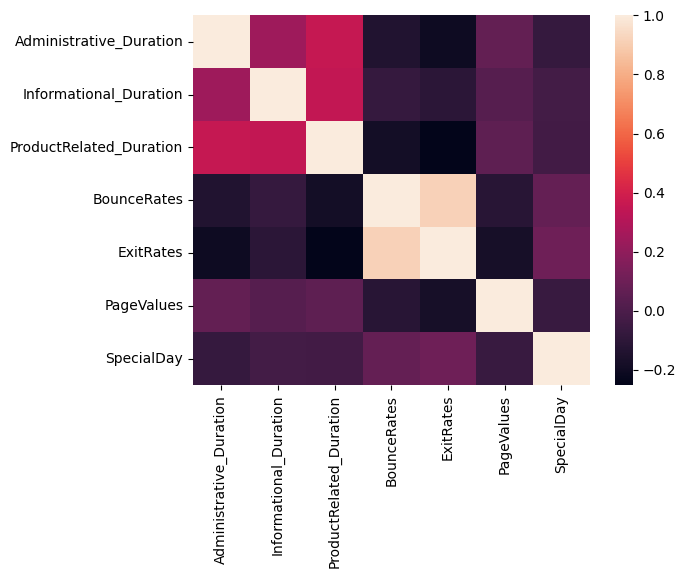

In [204]:
corr = df.select_dtypes(float).corr()
sns.heatmap(corr);
corr

In [205]:
df.drop('BounceRates', axis=1, inplace=True)

- There are some Outliers in our columns we will try to detect them Using The IQR method

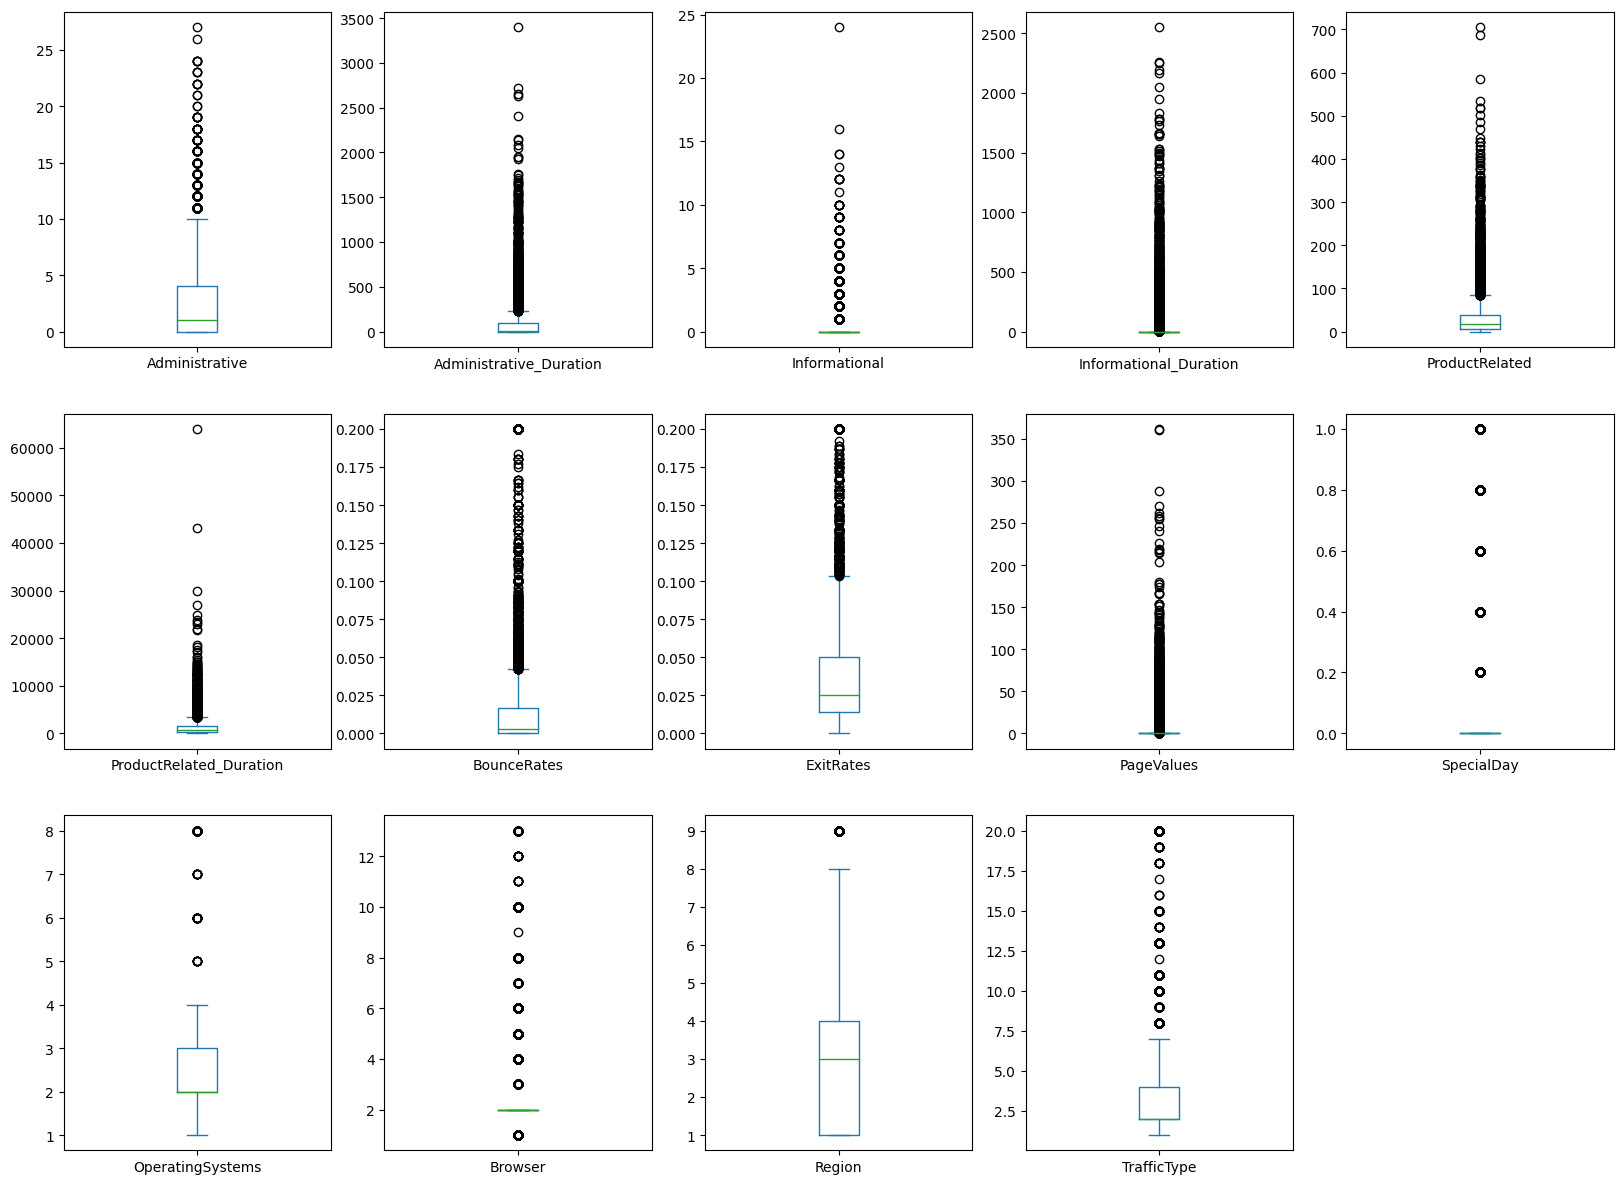

In [206]:
numerical_data = online_shoppers.select_dtypes(exclude='object')
numerical_data.plot(kind='box', subplots=True,\
                    sharex=False, sharey=False,\
                    figsize=(20, 20),  layout=(4, 5))

plt.savefig('figs/Box Plots.png', format='png')

- Getting the indecies of the outliers. I can't Drop all the outliers because the it contains 190 y-yes values so we may drop the y-no rows but keeping the y-yes rows.

In [207]:
# q3, q1 = np.percentile(df['PageValues'], [90, 10])
# print(q3, q1)
# print(len(df))

# IQR = q3 - q1
# print(IQR)

# upper_bound = q3 + 1.5 * IQR
# lower_bound = q1 - 1.5 * IQR

In [208]:
# mask1 = df['PageValues'] > upper_bound
# mask2 = df['PageValues'] < lower_bound

# outliers_indecies = df[(mask1) | (mask2)].index

# len(outliers_indecies)

In [209]:
# df.loc[outliers_indecies]['Revenue'].value_counts()

In [210]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.select_dtypes(float)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data.sort_values('VIF', ascending=False)

,feature,VIF
2,ProductRelated_Duration,1.526322
0,Administrative_Duration,1.363230
1,Informational_Duration,1.226583
3,ExitRates,1.112060
5,SpecialDay,1.085227
4,PageValues,1.054449


- Handling the imbalanced target variable.

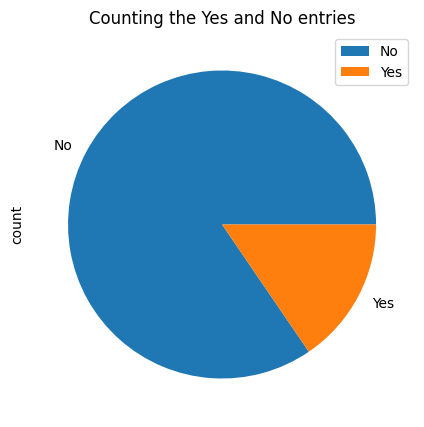

In [211]:
df['Revenue'].value_counts().plot.pie(labels=['No', 'Yes'], figsize=(10, 5))
plt.legend()
plt.title('Counting the Yes and No entries')
plt.savefig('figs/Counting the Yes and No entries.png', format='png')
plt.show()

- Splitting the data

In [212]:
X =  df.drop('Revenue', axis=1)
y = df['Revenue']

- Baseline Accuracy

In [213]:
basline_acc = y.value_counts(normalize=True).max()
print("the Baseline Model", round(basline_acc, 2))

the Baseline Model 0.85


In [214]:
# from sklearn.decomposition import PCA

# # Apply PCA
# pca = PCA(n_components=15)  # Choose the number of components
# X_pca = pca.fit_transform(X)

# # Explained variance ratio
# explained_variance_ratio = pca.explained_variance_ratio_

# # Transform the original data using the selected number of components
# X = pca.transform(X)

# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance Ratio')
# plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
# plt.grid(True)
# plt.show()

- I will go with the GradientBoostingClassifier.

In [215]:
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X)

Knn 0.8516626115166261 0.009716802921430052
svc 0.8730738037307381 0.01089319279181236
Dtc 0.8603406326034063 0.00561078039137971
Rdf 0.9011354420113544 0.006146730031304612
adb 0.8913219789132197 0.006292673070971893
grdb 0.9017031630170317 0.006827119385477662
Gaus 0.7634225466342256 0.010419763068303571
LDA 0.8798053527980535 0.008759875009114106
LogR 0.8762368207623682 0.009546067810550804
MLP 0.897161394971614 0.004570641623229631


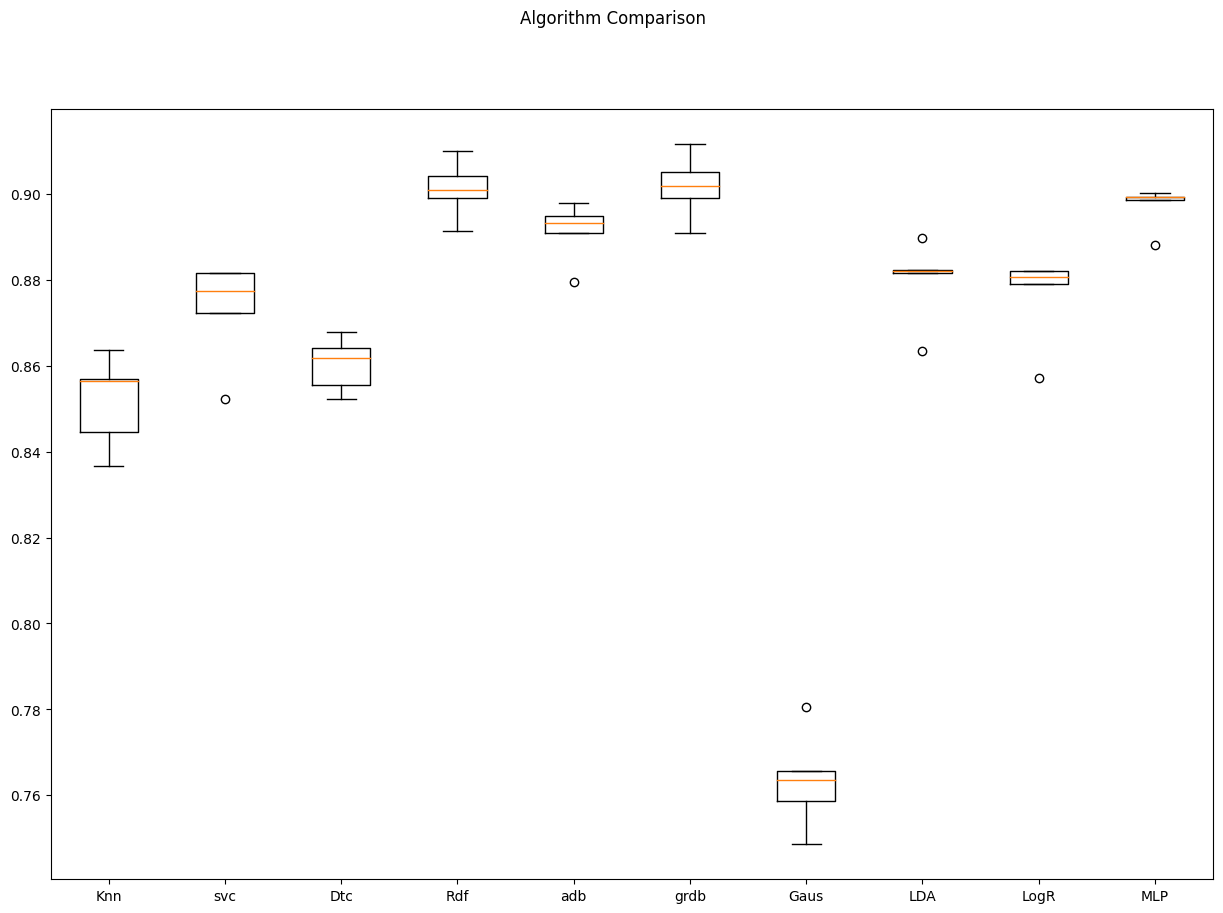

In [216]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score

models = [
    ('Knn', KNeighborsClassifier()),
    ('svc', SVC()),
    ('Dtc', DecisionTreeClassifier()),
    ('Rdf', RandomForestClassifier()),
	('adb', AdaBoostClassifier()),
    ('grdb', GradientBoostingClassifier()),
    ('Gaus', GaussianNB()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('LogR', LogisticRegression()),
    ('MLP', MLPClassifier())
]
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0, shuffle=True)
    cv_results = cross_val_score(model, X_scaled, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(name, cv_results.mean(), cv_results.std())
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('figs/Models Comparison.png',  format='png')
plt.show()

In [217]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [218]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

under_samp = RandomUnderSampler()
over_samp = RandomOverSampler()
smote = SMOTE()

X_under, y_under = under_samp.fit_resample(X_train, y_train)
X_over, y_over = over_samp.fit_resample(X_train, y_train)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

- The Results Suggests that we go with the Original X_train, y_train sets.

In [219]:
model_under = RandomForestClassifier().fit(X_under, y_under)
print(model_under.score(X_test, y_test))

model_over = RandomForestClassifier().fit(X_over, y_over)
print(model_over.score(X_test, y_test))

model_smote = RandomForestClassifier().fit(X_smote, y_smote)
print(model_smote.score(X_test, y_test))

model_original = RandomForestClassifier().fit(X_train, y_train)
print(model_original.score(X_test, y_test))

0.851581508515815
0.8921330089213301
0.8941605839416058
0.8921330089213301


In [220]:
from  sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Evaluating the model with the Classification Metrics
pred = model_smote.predict(X_test)

CM_RF = confusion_matrix(y_test, pred)
CR_RF = classification_report(y_test, pred)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, pred)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}
# Showing the results of the model
for measure in resultsRF:
    print(measure,": \n", resultsRF[measure])

Confusion Matrix : 
 [[1935  120]
 [ 141  270]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      2055
           1       0.69      0.66      0.67       411

    accuracy                           0.89      2466
   macro avg       0.81      0.80      0.81      2466
weighted avg       0.89      0.89      0.89      2466

Area Under Curve : 
 0.7992700729927007


In [221]:
from sklearn.model_selection import GridSearchCV


# Create the GradientBoostingClassifier
clf = GradientBoostingClassifier()

# Define the hyperparameter grid
params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(50, 100, 10),
    'max_depth': range(3, 6)
}

# Perform grid search using cross-validation
gbc_model = GridSearchCV(clf, param_grid=params, cv=5,n_jobs=-1, verbose=1)

# Fit the grid search to the data
gbc_model.fit(X_smote, y_smote)

# Print the best parameters and best score
print("Best Parameters:", gbc_model.best_params_)
print("Best Score:", gbc_model.best_score_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 90}
Best Score: 0.9137706175749362


In [222]:
acc_train = gbc_model.score(X_smote, y_smote)
acc_test = gbc_model.score(X_test, y_test)

print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 0.9501
Model Test Accuracy: 0.8881


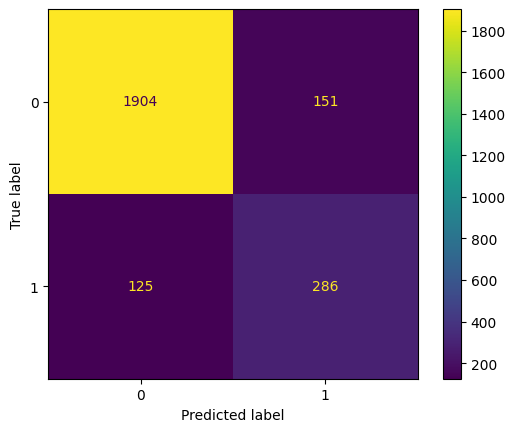

In [223]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(gbc_model, X_test, y_test)

plt.savefig("figs/GradientBoosting GridSearch.png", dpi=150)

In [224]:
# Evaluating the model with the Classification Metrics
pred = gbc_model.predict(X_test)

CM_RF = confusion_matrix(y_test, pred)
CR_RF = classification_report(y_test, pred)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, pred)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}
# Showing the results of the model
for measure in resultsRF:
    print(measure,": \n", resultsRF[measure])

Confusion Matrix : 
 [[1904  151]
 [ 125  286]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      2055
           1       0.65      0.70      0.67       411

    accuracy                           0.89      2466
   macro avg       0.80      0.81      0.80      2466
weighted avg       0.89      0.89      0.89      2466

Area Under Curve : 
 0.8111922141119221


# -------------------------------------------------------------

In [225]:
from sklearn.model_selection import GridSearchCV


# Create the GradientBoostingClassifier
clf = RandomForestClassifier()

params = {
    'n_estimators': range(50, 300, 50),
    'max_depth': range(3, 6)
}

# Perform grid search using cross-validation
rfc_model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
rfc_model.fit(X_smote, y_smote)

# Print the best parameters and best score
print("Best Parameters:", rfc_model.best_params_)
print("Best Score:", rfc_model.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'max_depth': 5, 'n_estimators': 100}
Best Score: 0.9022359729770226


In [226]:
acc_train = rfc_model.score(X_smote, y_smote)
acc_test = rfc_model.score(X_test, y_test)

print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 0.9043
Model Test Accuracy: 0.8779


In [227]:
# Evaluating the model with the Classification Metrics
pred = rfc_model.predict(X_test)

CM_RF = confusion_matrix(y_test, pred)
CR_RF = classification_report(y_test, pred)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, pred)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}
# Showing the results of the model
for measure in resultsRF:
    print(measure,": \n", resultsRF[measure])

Confusion Matrix : 
 [[1837  218]
 [  83  328]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      2055
           1       0.60      0.80      0.69       411

    accuracy                           0.88      2466
   macro avg       0.78      0.85      0.80      2466
weighted avg       0.90      0.88      0.88      2466

Area Under Curve : 
 0.8459854014598539


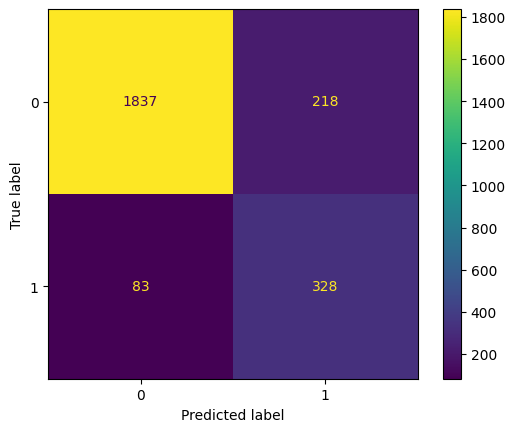

In [228]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rfc_model, X_test, y_test)

plt.savefig("figs/RandomForest GridSearch.png", dpi=150)

- I will save the RandomForestClassifier as it represented the best Scores

In [229]:
import pickle
# save the model to disk
filename = 'finalized_model_random_forest_gridsearch.sav'
pickle.dump(rfc_model, open(filename, 'wb'))

In [230]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8779399837793999
